In [1]:
#plot vertical motion cross section with different terrain resolutions, at a single point
#Credit to WRF-Python for providing some of the code for this script

In [1]:
import os
import subprocess
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from cartopy import feature as cfeat
import cartopy.crs as ccrs
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)

In [8]:
#file of interest, I have some commented out because I was changing the time/WRF run (going to automate this in the future for ensembles)
#dates of interest for vertical motion over mtns for Ivan: 09/17 at 00Z to 09/18 at 00Z
wrf_file = Dataset("/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-17_03:00:00") #run with no CP on, and epssm =0.3
#wrf_file = Dataset("/scratch/amanda/ivan_ensembles/ens1_ivan/hourly_d01_2004-09-17_03:00:00") #run with no CP on inner doms, but no epssm yet
#wrf_file = Dataset("/scratch/amanda/ivan_hires_ctrl_3dom_30s_terr/wrfout_d03_2004-09-17_03:00:00") original run, CP on and no epssm yet

plotsdir = '/home/jupyter-amsinnin@ncsu.edu/Ivan/Ivan_ctrl_plots/vertical_motion_plots'
if os.path.isdir(plotsdir) != 1:
    subprocess.call(["mkdir","-p",plotsdir])
os.chdir(plotsdir)

In [10]:
#transect through the mtns, centered at lat/lon of landslide location at box culvert (35.3089,-83.6443) (point of interest)

#transect is along the same lat 
#WHEN DID THIS LANDSLIDE HAPPEN? would be interesting to compare RRs and vert motion at this loc with the time of the landslide and runoff
pt_lat = 35.3089 #lat/lon for the central interest point
pt_lon = -83.6443
start_lat = pt_lat +.25 #start lat for cross section orig .25, extended to see more of slope (extended is .50)
end_lat = pt_lat -.25 #end lat for cross section
start_lon = pt_lon -.25
end_lon= pt_lon + .25
cross_start = CoordPair(lat=start_lat, lon=start_lon)
cross_end = CoordPair(lat=end_lat, lon=end_lon)

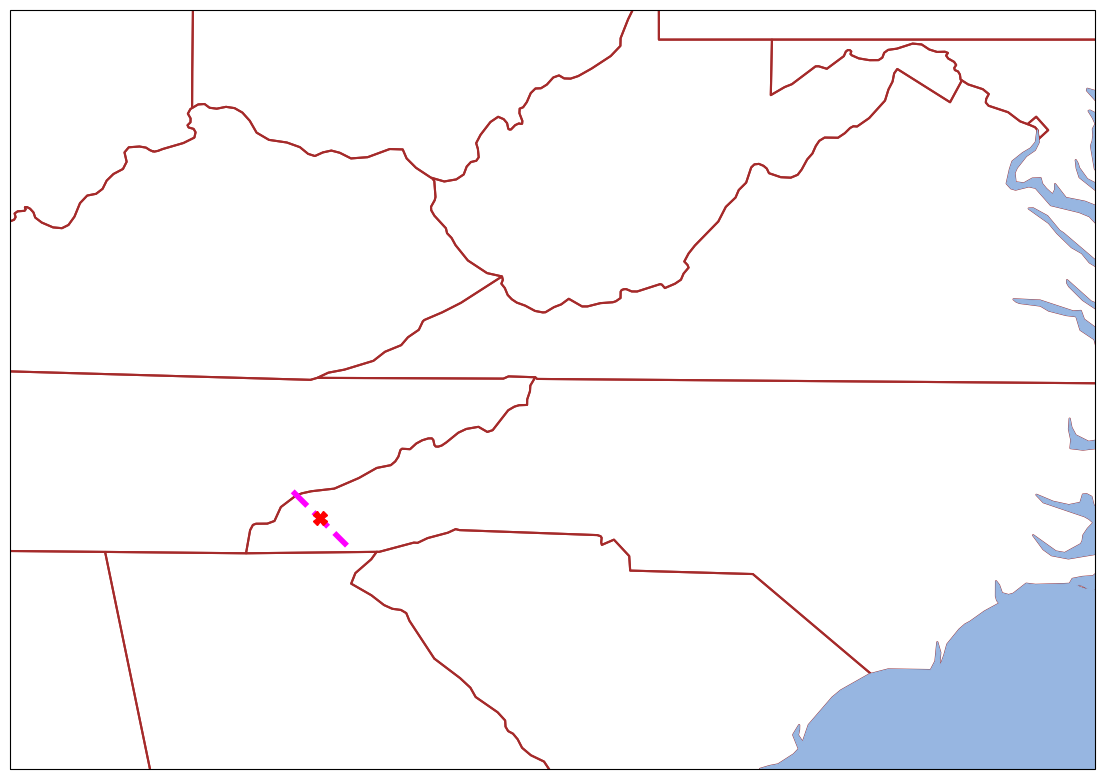

In [11]:
#testing location of cross section

lat = getvar(wrf_file, "XLAT", timeidx=-1)
lon = getvar(wrf_file, "XLONG", timeidx=-1)

plotproj = crs.PlateCarree()#(central_longitude=-85., central_latitude=30.,standard_parallels=[30, 60])
fig = plt.figure(figsize=(14,10))
ax=plt.subplot(111, projection=plotproj)
ax.set_extent([-86.5, -76.5, 33, 40],crs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.5, edgecolor='brown')
ax.coastlines('50m', linewidth=0.4)
    
# Add height contours with shaded PV 
rain_levels = np.arange(1, 25, 0.5)
pmsl_levels = np.arange(900, 1060, 4)
hgt_levels = np.arange(0, 2500, 2)
# contours = plt.contour(to_np(lon), to_np(lat), to_np(smooth_slp), levels=pmsl_levels, colors="black", alpha= .9, linewidths = 3,linestyles='solid',transform=crs.PlateCarree())
# plt.clabel(contours, inline=1, fontsize=10, fmt="%i") 
#
sea_mask = NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeat.COLORS['water'])
ax.add_feature(sea_mask, zorder=2)
    
ax.plot([start_lon, end_lon], [start_lat, end_lat], transform=ccrs.PlateCarree(), color='magenta', linestyle= 'dashed',linewidth=4)
plt.plot(-83.6443,35.3089 , marker= 'X', color='red', markersize=10)


In [15]:
# Get the WRF variables
#w = wrf_file.variables["W"][0,:,:]
w = getvar(wrf_file, "W", timeidx=-1)[1:,:,:] #w-component of wind on mass points (m/s)
ht = getvar(wrf_file, "z", timeidx=-1)
ter = getvar(wrf_file, "ter", timeidx=-1)
dbz = getvar(wrf_file, "dbz", timeidx=-1)
max_dbz = getvar(wrf_file, "mdbz", timeidx=-1)
Z = 10**(dbz/10.) # Use linear Z for interpolation

print(np.shape(w))
print(np.shape(ht))
# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
w_cross = vertcross(w, ht, wrfin=wrf_file,
                    start_point=cross_start,
                    end_point=cross_end,
                    latlon=True, meta=True)

# Convert back to dBz after interpolation
#w_cross = 10.0 * np.log10(z_cross)

# Add back the attributes that xarray dropped from the operations above
w_cross.attrs.update(w_cross.attrs)
w_cross.attrs["description"] = "vertical motion cross section"
w_cross.attrs["units"] = "m/s"

print(np.max(w))

(49, 630, 468)
(49, 630, 468)
<xarray.DataArray 'W' ()>
array(19.805557, dtype=float32)
Coordinates:
    Time     datetime64[ns] 2004-09-17T03:00:02


In [13]:
# To remove the slight gap between the dbz contours and terrain due to the
# contouring of gridded data, a new vertical grid spacing, and model grid
# staggering, fill in the lower grid cells with the first non-missing value
# for each column.

# Make a copy of the z cross data. Let's use regular numpy arrays for this.
w_cross_filled = np.ma.copy(to_np(w_cross))

# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(w_cross_filled.shape[-1]):
    column_vals = w_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    w_cross_filled[0:first_idx, i] = w_cross_filled[first_idx, i]

# Get the terrain heights along the cross section line
ter_line = interpline(ter, wrfin=wrf_file, start_point=cross_start,
                      end_point=cross_end)

# Get the lat/lon points
lats, lons = latlon_coords(w)

# Get the cartopy projection object
cart_proj = get_cartopy(w)

print(np.max(w))
print(np.min(w))

<xarray.DataArray 'W' ()>
array(19.805557, dtype=float32)
Coordinates:
    Time     datetime64[ns] 2004-09-17T03:00:02
<xarray.DataArray 'W' ()>
array(-12.132961, dtype=float32)
Coordinates:
    Time     datetime64[ns] 2004-09-17T03:00:02


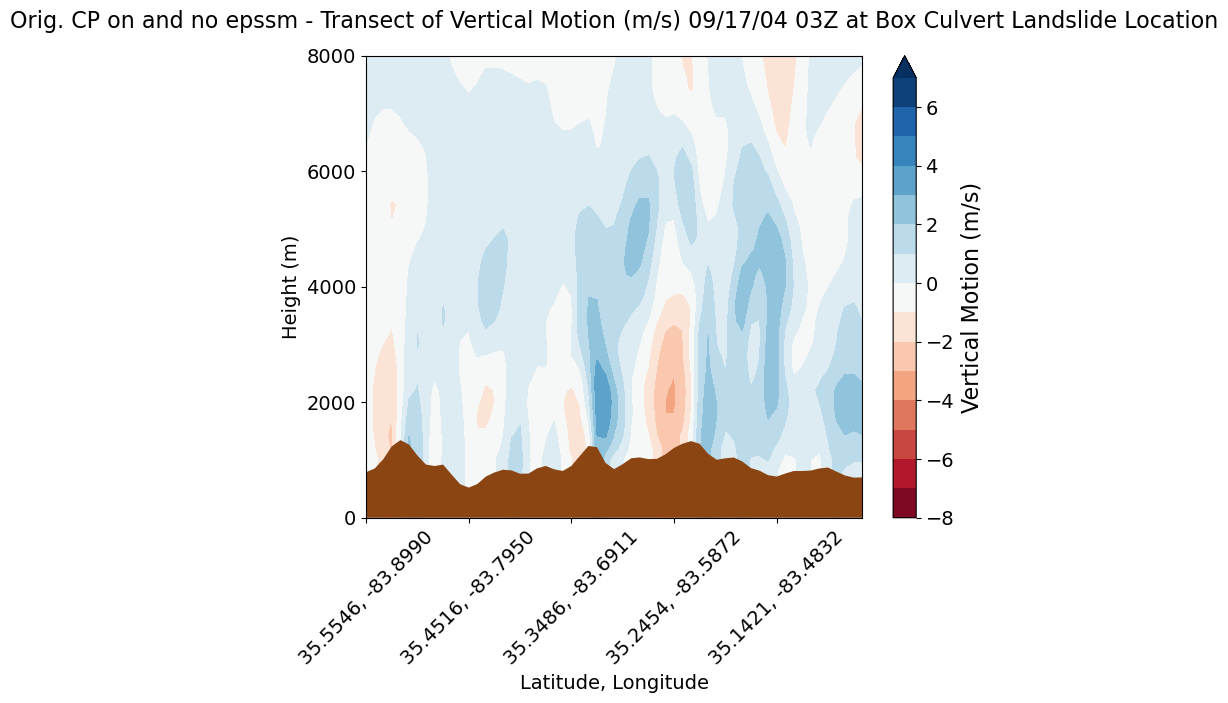

In [17]:
# Create the figure
fig = pyplot.figure(figsize=(8,6))
# Create a figure and axis object
#fig, ax = plt.subplots()
ax_cross = pyplot.axes()

#w_levels = np.arange(-2., 2., 1.) made for 09/17 21Z, the hours before that have some much stronger vert motion
w_levels = np.arange(-8., 8., 1.)
#w_map, w_norm = from_levels(w_levels,extend="max")

# Make the cross section plot for dbz
#w_levels = np.arange(-2.1,2.1,.1)
xs = np.arange(0, w_cross.shape[-1], 1)
ys = to_np(w_cross.coords["vertical"])
w_contours = ax_cross.contourf(xs,
                                 ys,
                                 to_np(w_cross_filled),
                                 levels=w_levels,
                                 cmap=get_cmap("RdBu"),
                                 extend="max")
# Add the color bar
cb_w = fig.colorbar(w_contours, ax=ax_cross, pad=0.05)
cb_w.set_label('Vertical Motion (m/s)', fontsize=16)            
cb_w.ax.tick_params(labelsize=14)

# Fill in the mountain area
ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),
                                facecolor="saddlebrown")

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(w_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
cb_w.set_label('Vertical Motion (m/s)', fontsize=16) 
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=14)
#

y_ticks = np.arange(0, 8001, 2000)
ax_cross.set_yticks(y_ticks)
ax_cross.set_yticklabels(y_ticks, fontsize=14)  # increase font size to 14

# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("Latitude, Longitude", fontsize=14)
ax_cross.set_ylabel("Height (m)", fontsize=14)
ax_cross.set_ylim([0, 8000])
# Add a title
ax_cross.set_title("Orig. CP on and no epssm - Transect of Vertical Motion (m/s) 09/17/04 03Z at Box Culvert Landslide Location", {"fontsize" : 16}, pad=20)
plt.savefig('orig_extended_boxculvert_hires_W_9_17_03z.png', dpi=300, bbox_inches='tight')
#box culvert seems to have a lot more long-lived vertical motion over the area(compared to MM37), the higher elevations seem to be in this region which could contribute    
#which was worse in terms of damage? will also look at runoff, etc
pyplot.show()